# Anomaly and Outlier Detection

In [17]:
#| label: load_dataset
#| code-fold: false

# Importing the required libraries
import numpy as np
import pandas as pd


# Load NSL-KDD dataset here
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_score"]

print(len(col_names))
file_path = 'KDDTrain+.txt'
traindata = pd.read_csv(file_path, sep=",", header=None, names=col_names)

# first five rows
# print(traindata.head(5))
print(traindata.shape)

file_path = 'KDDTest+.txt'
testdata = pd.read_csv(file_path, sep=",", header=None, names=col_names)
print(testdata.shape)

# Dropping unnecessary column
traindata = traindata.drop('difficulty_score', axis=1)
testdata = testdata.drop('difficulty_score', axis=1)

43
(125973, 43)
(22544, 43)


In [18]:
#| label: encode_categorical
#| code-fold: false

# Insert categorical features into a 2D numpy array
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

# Get the categorical values into a 2D numpy array
df_categorical_values = traindata[categorical_columns]
testdf_categorical_values = testdata[categorical_columns]
# df_categorical_values.head()

# protocol type
unique_protocol=sorted(traindata.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(traindata.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(traindata.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
# print(dumcols)

#do same for test set
# Test set has fewer (70-64 = 6) categories for 'service'
unique_service_test=sorted(testdata.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
# print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

# df_cat_data.head()


In [19]:
#| label: categorical_match
#| code-fold: false
trainservice=traindata['service'].tolist()
testservice= testdata['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

newdf=traindata.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=testdata.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
# print(newdf.shape)
# print(newdf_test.shape)

traindata = newdf
# print(traindata.shape)
# print(traindata.head())
testdata = newdf_test
# print(testdata.shape)

# fixing the sequence
column_list = list(traindata.columns)
column_list.remove('label')
column_list.append('label')

traindata = traindata[[x for x in column_list]]
# print(traindata.head())

testdata = testdata[[x for x in column_list]]
# print(testdata.head())

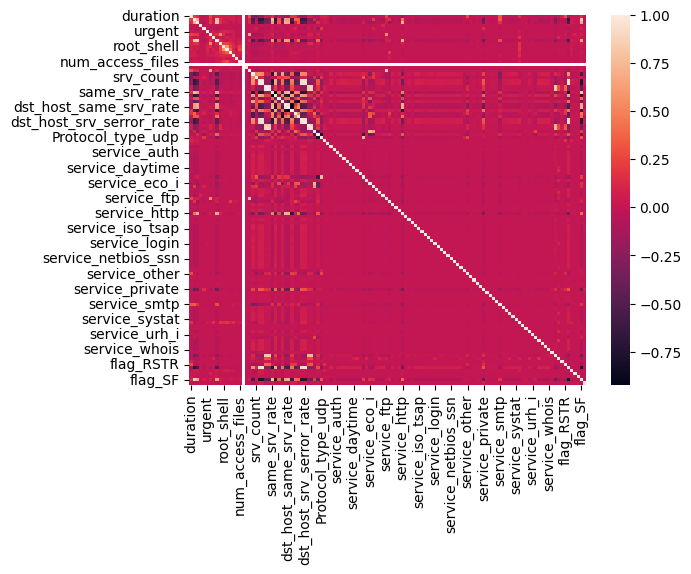

In [20]:
#| label: correlation
#| code-fold: false

# Correlation matrix
corr_matrix = traindata.corr(method = 'spearman')
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(corr_matrix, annot=False)
# plt.savefig(f'plots/Spearman Correlation for Training Data.png')
plt.show()

# We have found out that feature 'num_outbound_cmds' is always zero. So we can drop this column
traindata = traindata.drop('num_outbound_cmds', axis=1)
testdata = testdata.drop('num_outbound_cmds', axis=1)


In [21]:
#| label: labelling
#| code-fold: false
traindata['label'] = traindata['label'].replace('normal', 0)
traindata['label'] = traindata['label'].astype(bool).astype(int)
# print(traindata['label'])

testdata['label'] = testdata['label'].replace('normal', 0)
testdata['label'] = testdata['label'].astype(bool).astype(int)
# print(testdata['label'])

In [22]:
#| label: split
#| code-fold: false
training_size = traindata.shape[0]
# print('Training size is:', training_size)
X_train = traindata.iloc[:training_size,:-1]
y_train = traindata.iloc[:training_size, -1]

X_test = testdata.iloc[:,:-1]
y_test = testdata.iloc[:, -1]

In [23]:
#| label: scale
#| code-fold: false
from sklearn.preprocessing import StandardScaler, MinMaxScaler
myScaler = MinMaxScaler()
# myScaler = StandardScaler()
X_train = myScaler.fit_transform(X_train)
X_test = myScaler.transform(X_test)
X_train.shape, X_test.shape

((125973, 121), (22544, 121))

Trainining with Naïve Bayes Classifier
Trainining for Naïve Bayes Classifier finished
Trainining with Bernoulli Naïve Bayes Classifier
Trainining for Bernoulli Naïve Bayes Classifier finished
Trainining with Decision Tree Classifier
Trainining for Decision Tree Classifier finished
Trainining with KNN Classifier
Trainining for KNN Classifier finished
Trainining with Random Forest Classifier
Trainining for Random Forest Classifier finished
Trainining with Logistic Regression
Trainining for Logistic Regression finished


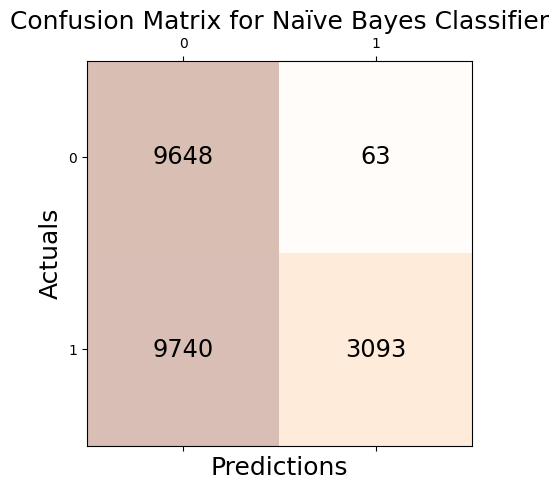

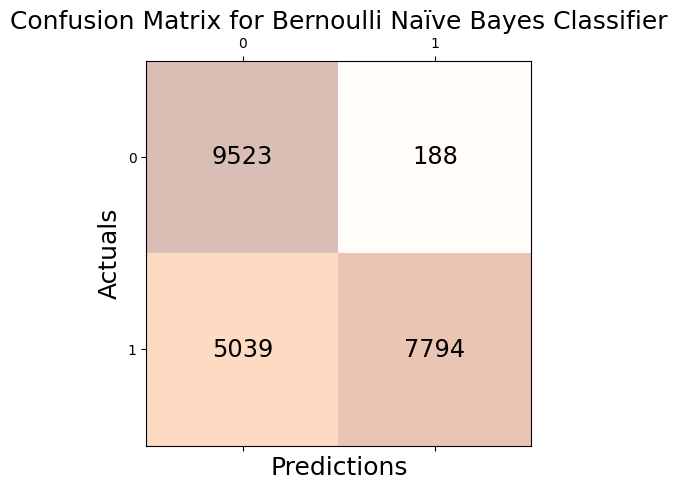

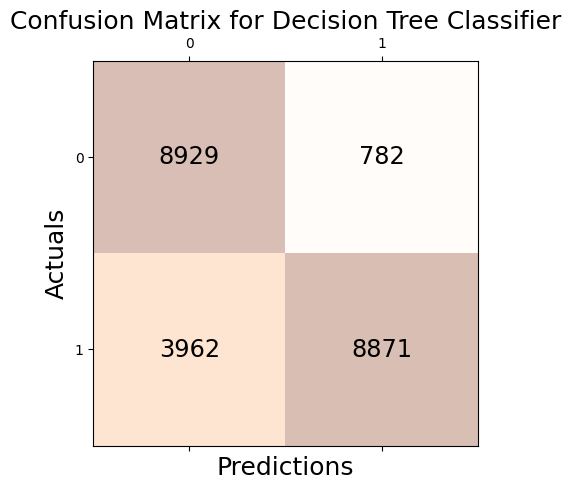

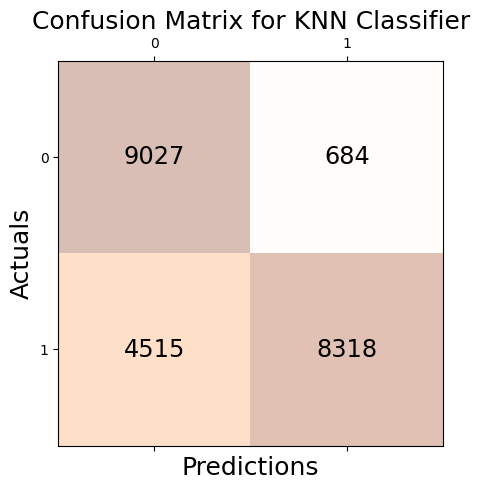

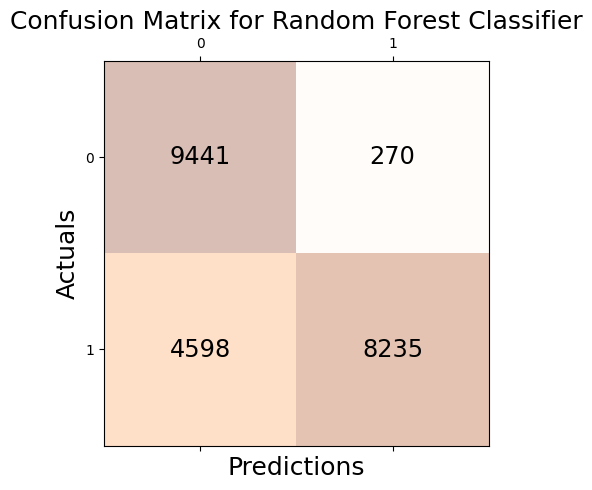

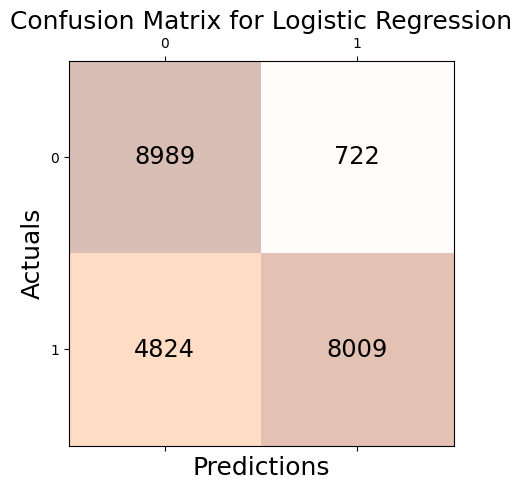

In [24]:
#| label: models
#| code-fold: false
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import warnings
from sklearn.metrics import r2_score, precision_recall_fscore_support, f1_score, ConfusionMatrixDisplay, confusion_matrix,precision_score, recall_score,accuracy_score
from sklearn.model_selection import cross_val_score


result_dict_test = {}

models = {'Naïve Bayes Classifier': GaussianNB, 'Bernoulli Naïve Bayes Classifier': BernoulliNB,
          'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}

warnings.filterwarnings("ignore")


for model_name, model_function in models.items():
    comparison_metrics  = []
    print(f'Trainining with {model_name}')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)


    #Obtain accuracy
    train_accuracy = np.mean(accuracies)
    # print("Train Score:",train_accuracy)
    comparison_metrics.append(train_accuracy)
    test_accuracy = model.score(X_test,y_test)
    comparison_metrics.append(test_accuracy)
    # print("Test Score:",test_accuracy)

    test_r2_score = r2_score(y_test, y_pred)
    # print("R2 Score:",test_r2_score)
    comparison_metrics.append(test_r2_score)

    per_class_precision = precision_score( y_test, y_pred, average=None)
    # print('Per-class precision score:', per_class_precision)
    comparison_metrics.append(per_class_precision[0])
    comparison_metrics.append(per_class_precision[1])
    test_recall = recall_score(y_test, y_pred)
    # print('Recall: ', test_recall)
    comparison_metrics.append(test_recall)

    test_f1_score = f1_score(y_test, y_pred, average='micro')

    # print("Test Score (F1 - micro):",test_f1_score)
    comparison_metrics.append(test_f1_score)


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # determining the metrics
    TN = conf_matrix[0][0]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    # print("True Positive", TP)
    FP = conf_matrix[0][1]
    # print("False Positive", FP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # print('False Positive Rate is: ', FPR)
    comparison_metrics.append(FPR)
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=18)
    # plt.show()

    #Store results in the dictionaries
    result_dict_test[model_name] = comparison_metrics
    print(f'Trainining for {model_name} finished')

                                  train_accuracy  test_r2_score  accuracy  \
Naïve Bayes Classifier                  0.857033       0.565161 -0.773364   
Bernoulli Naïve Bayes Classifier        0.898486       0.768142  0.054435   
Decision Tree Classifier                0.997333       0.789567  0.141810   
KNN Classifier                          0.995904       0.769384  0.059500   
Random Forest Classifier                0.998254       0.784067  0.119378   
Logistic Regression                     0.972431       0.753992 -0.003272   

                                  benign_precision  anomaly_precision  \
Naïve Bayes Classifier                    0.497627           0.980038   
Bernoulli Naïve Bayes Classifier          0.653962           0.976447   
Decision Tree Classifier                  0.692654           0.918989   
KNN Classifier                            0.666593           0.924017   
Random Forest Classifier                  0.672484           0.968254   
Logistic Regression   

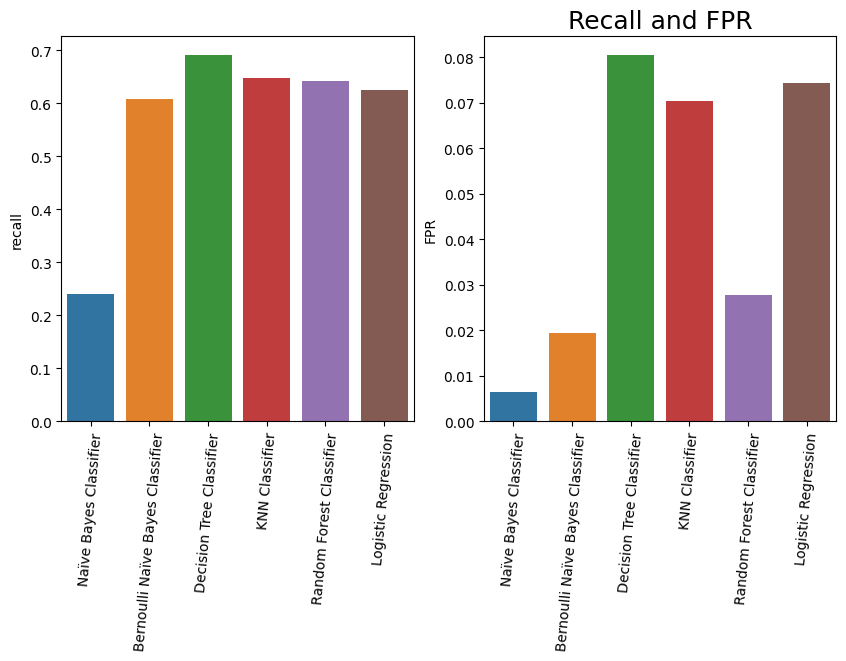

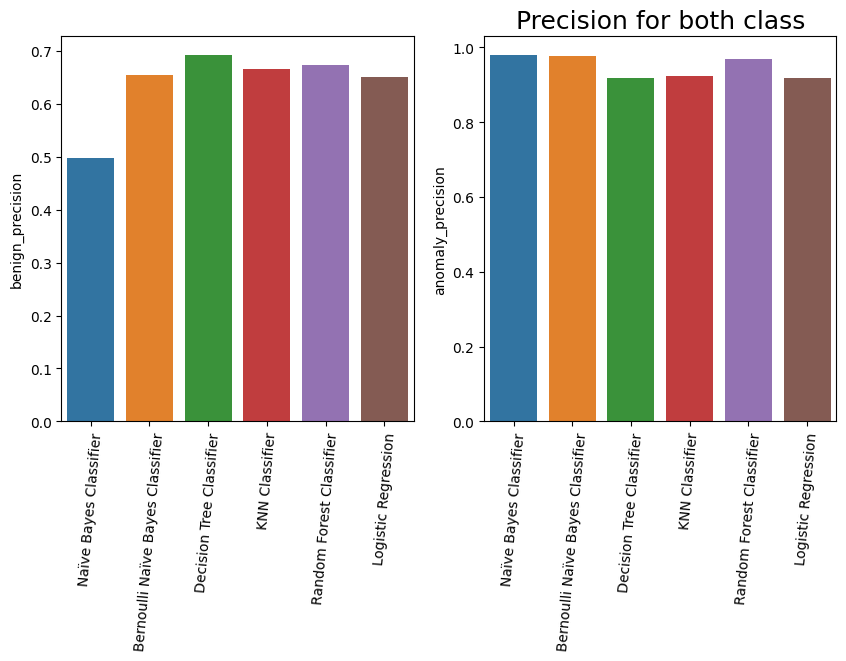

In [25]:
#| label: compare
#| code-fold: false

# Compare Accuracy Scores
df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index", columns=[ 'train_accuracy', 'test_r2_score',
                'accuracy', 'benign_precision', 'anomaly_precision', 'recall', 'f1_score', 'FPR'])
print(df_result_test)


# Display the accuracy scores
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_test.index,y = df_result_test.recall,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.FPR,ax = ax[1])
ax[0].set_xticklabels(df_result_test.index,rotation = 85)
ax[1].set_xticklabels(df_result_test.index,rotation = 85)
plt.title('Recall and FPR', fontsize=18)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_test.index,y = df_result_test.benign_precision,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.anomaly_precision,ax = ax[1])
ax[0].set_xticklabels(df_result_test.index,rotation = 85)
ax[1].set_xticklabels(df_result_test.index,rotation = 85)
plt.title('Precision for both class', fontsize=18)
plt.show()